In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import Callback, ModelCheckpoint
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.models import Sequential, load_model
from keras.utils import np_utils
import keras.backend as K

# Keras implementation of Phased LSTM [https://arxiv.org/abs/1610.09513], from NIPS 2016.
# To install run: `pip install phased_lstm_keras`
from phased_lstm_keras.PhasedLSTM import PhasedLSTM as PLSTM

Using TensorFlow backend.


In [2]:
# 数据集读取及预处理
def read_dataset(filepath):
    print(filepath)
    
    #读取原始数据集，保留原始数据文件，日期格式转换，设置日期为索引列
    data_raw = pd.read_csv(filepath_or_buffer=filepath, usecols=['DATE','DAILY_NET_SALES_UOM_QTY'], 
                           parse_dates={'Timeline':['DATE']}, index_col='Timeline')

    print('shape before dropna:', data_raw.shape)

    #去除qty值为NaN的行，*另可考虑填充均值
    data_raw = data_raw.dropna()
    #pandas 0.20版本，sort() => sort_index()，按日期排序
    data_raw = data_raw.sort_index()

    print('shape after dropna:', data_raw.shape)    
    print(data_raw.describe())

    
    return data_raw

# 建立训练和测试数据集
def create_dataset(dataset, seq_leg=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_leg-1):
        a = dataset[i:(i+seq_leg)]
        dataX.append(a)
        dataY.append(dataset[i + seq_leg])
    return np.array(dataX), np.array(dataY)

In [3]:
# 用于在训练过程中记录accuracy和loss的变化值
class MapeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get(mape))


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        

def mape(y_true, y_pred):
    # 此处如果/y_true, 在训练过程中，y_true会变成0，导致inf，因为数据集中最小值归一化后变成了0
    return abs(y_true-y_pred)

In [4]:
# 建立Phased LSTM模型
def bulid_model_plstm(layers):
    model = Sequential()
    
    model.add(PLSTM(
        input_shape=(layers[1], layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(PLSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=layers[3], activation='linear'))

    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[mape])
    model.summary()

    return model


# 建立标准LSTM模型
def bulid_model_lstm(layers):
    model = Sequential()
    
    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=layers[3], activation='linear'))

    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[mape])
    model.summary()

    return model

train_data_mv.csv
shape before dropna: (2445, 1)
shape after dropna: (2358, 1)
       DAILY_NET_SALES_UOM_QTY
count              2358.000000
mean                186.195081
std                  75.433074
min                  52.000000
25%                 143.000000
50%                 172.000000
75%                 210.000000
max                 901.000000


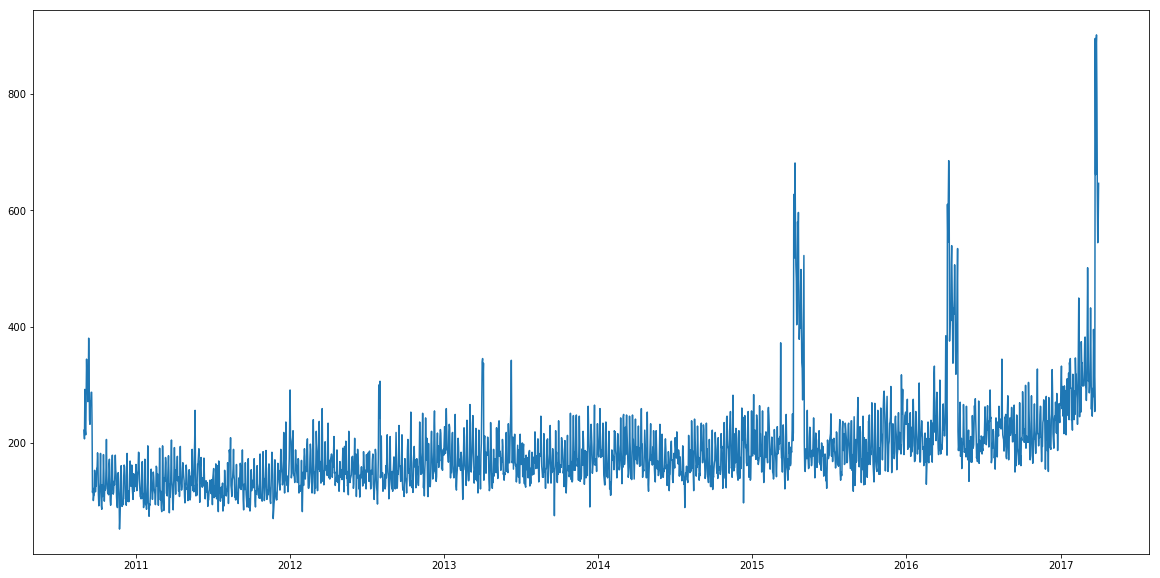

In [5]:
if __name__ == "__main__":
    
    # 读取原始数据集，数据可视化
    train_raw = read_dataset('train_data_mv.csv')
    
    plt.figure(figsize=(20,10))
    plt.plot(train_raw)
    plt.show()

test_data_mv.csv
shape before dropna: (120, 1)
shape after dropna: (119, 1)
       DAILY_NET_SALES_UOM_QTY
count               119.000000
mean                317.411765
std                 108.731859
min                 168.000000
25%                 253.000000
50%                 281.000000
75%                 338.000000
max                 718.000000


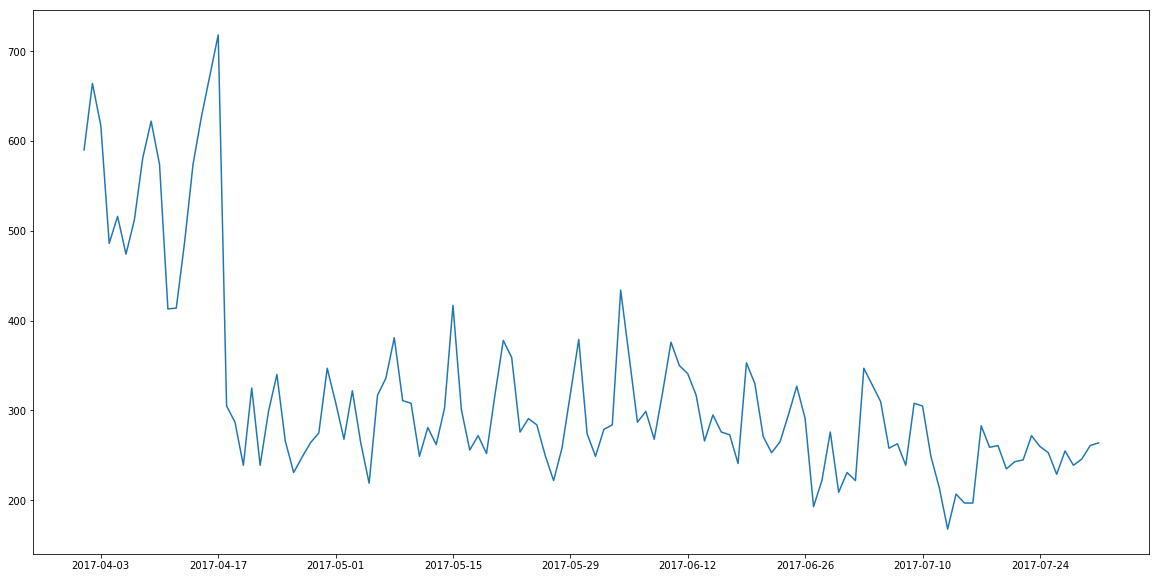

In [6]:
    test_raw = read_dataset('test_data_mv.csv') 
   
    plt.figure(figsize=(20,10))
    plt.plot(test_raw)  
    plt.show()

In [7]:
    # 数据归一化处理
    scaler = MinMaxScaler(feature_range=(0, 1))
    train = scaler.fit_transform(train_raw)
    test = scaler.fit_transform(test_raw)
    
    print(train.shape)
    print(train[:5])
    
    print(test.shape)
    print(test[:5])

(2358, 1)
[[ 0.20023557]
 [ 0.18256773]
 [ 0.28268551]
 [ 0.19905771]
 [ 0.19081272]]
(119, 1)
[[ 0.76727273]
 [ 0.90181818]
 [ 0.81636364]
 [ 0.57818182]
 [ 0.63272727]]


In [8]:
    seq_len = 30
    
    trainX, trainY = create_dataset(train, seq_len)
    
    test_addon = np.concatenate((train[len(train)-seq_len:len(train)],test))
    
    print(test_addon.shape)
    
    testX, testY = create_dataset(test_addon, seq_len)
    
    #trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
    #testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1))
    
    print(trainX.shape, trainY.shape)
    #print(trainX[0], trainY[0])
    #print(trainX[1], trainY[1])
    
    print(testX.shape, testY.shape)

(149, 1)
(2327, 30, 1) (2327, 1)
(118, 30, 1) (118, 1)


In [9]:
    batch_size = 8
    nb_epoch = 25
    is_train = False
    
    # 训练PLSTM网络
    #model_PLSTM = build_model_plstm(look_back)   
    
    mape_PLSTM = MapeHistory()
    loss_PLSTM = LossHistory()
    #model_PLSTM.fit(trainX, trainY, epochs=nb_epoch, batch_size=batch_size, callbacks=[acc_PLSTM, loss_PLSTM])
    
    #score_PLSTM = model_PLSTM.evaluate(testX, testY, verbose=0)
    
    model_PLSTM = bulid_model_plstm([1, seq_len, seq_len*2, 1])
    
    #acc_LSTM = AccHistory()
    loss_PLSTM = LossHistory()
    
    checkpoint_fixed_name = ModelCheckpoint("model_plstm_best_e{epoch:02d}-{val_loss:.4f}.hd5", 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)
    
    if is_train:
        model_PLSTM.fit(trainX, trainY, epochs=nb_epoch, batch_size=batch_size,
                       validation_split=0.05, callbacks=[loss_PLSTM, mape_PLSTM, checkpoint_fixed_name])
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
phased_lstm_1 (PhasedLSTM)   (None, 30, 30)            3930      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
phased_lstm_2 (PhasedLSTM)   (None, 60)                22020     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 26,011
Trainable params: 26,011
Non-trainable params: 0
_________________________________________________________________


In [10]:
    # 训练LSTM网络
    model_LSTM = bulid_model_lstm([1, seq_len, seq_len*2, 1])
    
    mape_PLSTM = MapeHistory()
    loss_LSTM = LossHistory()
    
    checkpoint_fixed_name = ModelCheckpoint("model_lstm_best_e{epoch:02d}-{val_loss:.4f}.hd5", 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)
    
    if is_train:
        model_LSTM.fit(trainX, trainY, epochs=nb_epoch, batch_size=batch_size,
                   validation_split=0.05, callbacks=[loss_LSTM, mape_PLSTM, checkpoint_fixed_name])
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 25,741
Trainable params: 25,741
Non-trainable params: 0
_________________________________________________________________


(2327, 1) (2327, 1)
Train Score: 0.128 MAPE
(118, 1) (118, 1)
Test Score: 0.444 MAPE


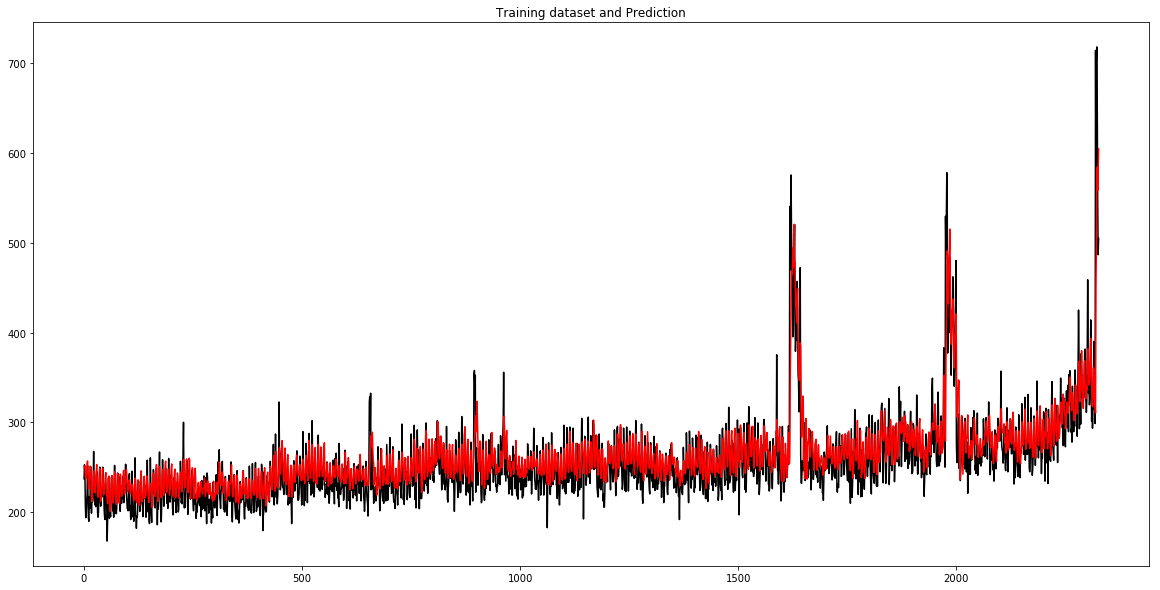

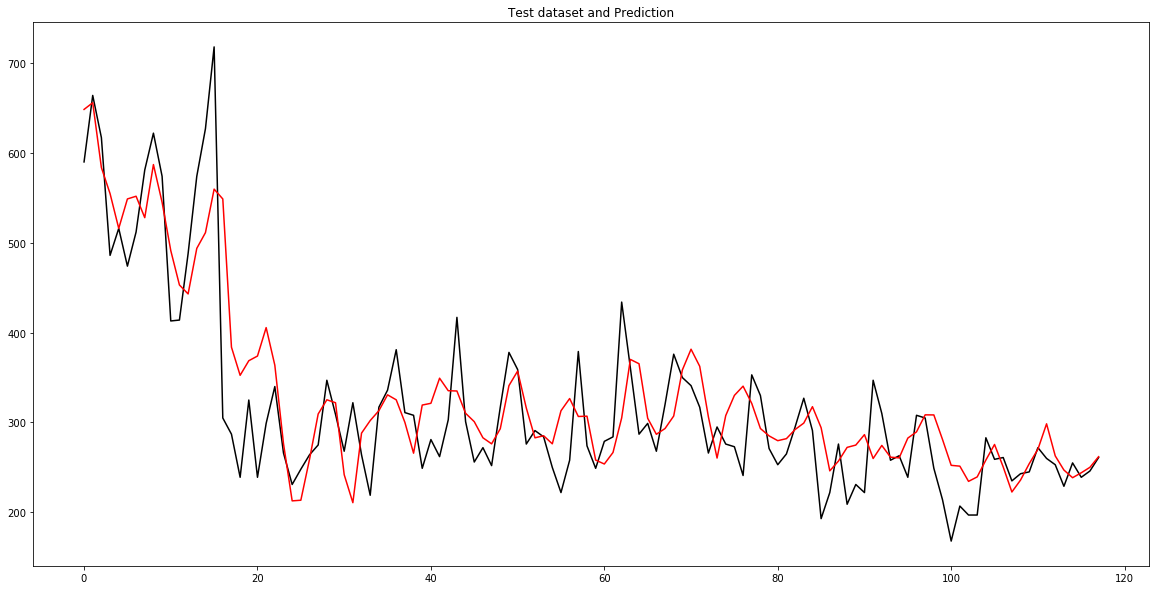

In [11]:
    if is_train == False:
        model_PLSTM.load_weights('model_plstm_best.hd5')
    
    # plstm预测结果
    
    trainPredict = model_PLSTM.predict(trainX)
    testPredict = model_PLSTM.predict(testX)
    
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_raw = scaler.inverse_transform(trainY)
    
    testPredict = scaler.inverse_transform(testPredict)
    testY_raw = scaler.inverse_transform(testY)
       
    print(trainY_raw.shape, trainPredict.shape)    
    trainScore = np.mean(abs((trainY_raw[0]-trainPredict[:,0])/trainY_raw[0]))
    print('Train Score: %.3f MAPE' % (trainScore))
    
    print(testY_raw.shape, testPredict.shape)
    testScore = np.mean(abs((testY_raw[0]-testPredict[:,0])/testY_raw[0]))
    print('Test Score: %.3f MAPE' % (testScore))
        
    # plot baseline and predictions    
    plt.figure(figsize=(20, 10))
    plt.title('Training dataset and Prediction')
    plt.plot(trainY_raw, color='k', label='TRUE')
    plt.plot(trainPredict, color='r', label='PRED')

    plt.show()
    
    
    # plot baseline and predictions    
    plt.figure(figsize=(20, 10))
    plt.title('Test dataset and Prediction')
    plt.plot(testY_raw, color='k', label='TRUE')
    plt.plot(testPredict, color='r', label='PRED')

    plt.show()

Train Score: 0.127 MAPE
Test Score: 0.445 MAPE


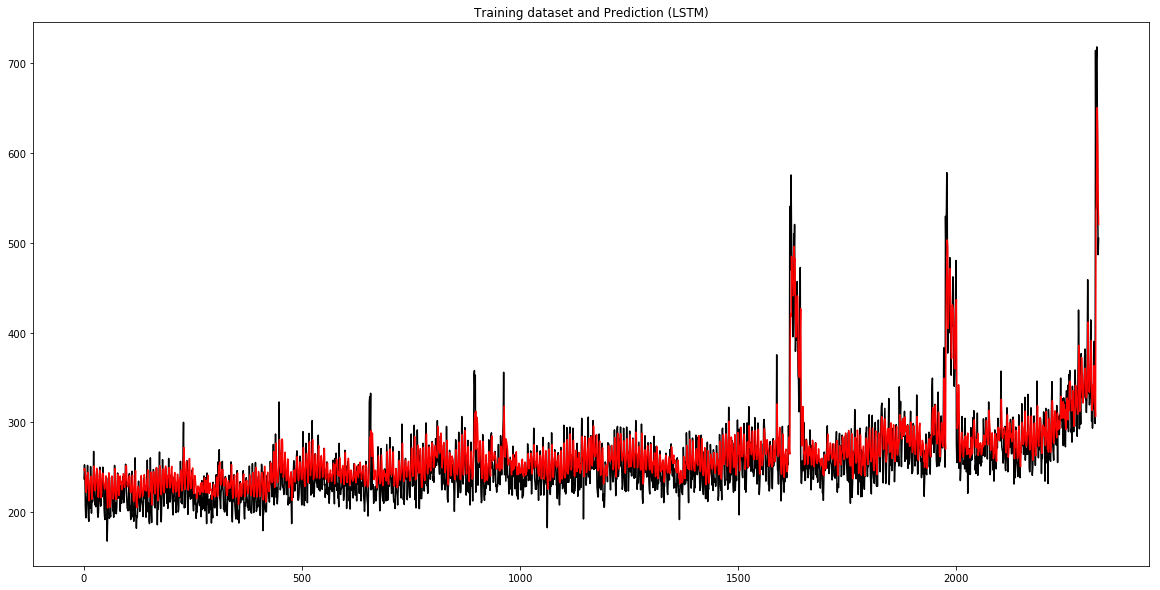

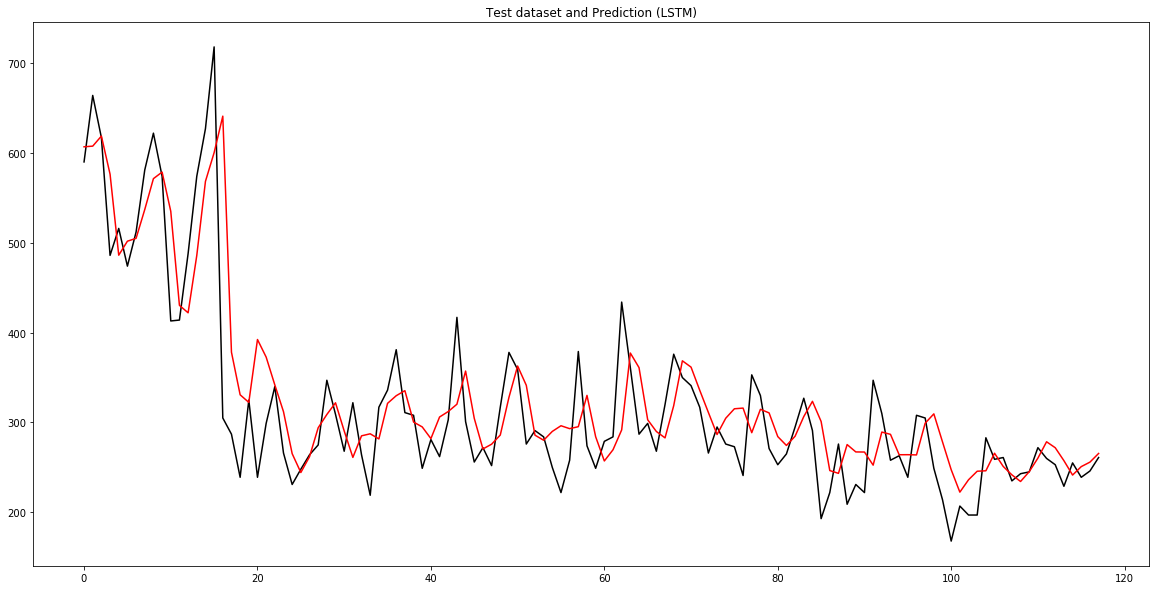

In [12]:
    if is_train == False:
        model_LSTM.load_weights('model_lstm_best.hd5')

    # lstm预测结果
    
    trainPredict = model_LSTM.predict(trainX)
    testPredict = model_LSTM.predict(testX)
    
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_raw = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY_raw = scaler.inverse_transform(testY)
    
    trainScore = np.mean(abs((trainY_raw[0]-trainPredict[:,0])/trainY_raw[0]))
    print('Train Score: %.3f MAPE' % (trainScore))
    
    testScore = np.mean(abs((testY_raw[0]-testPredict[:,0])/testY_raw[0]))
    print('Test Score: %.3f MAPE' % (testScore))
    
    # plot baseline and predictions    
    plt.figure(figsize=(20, 10))
    plt.title('Training dataset and Prediction (LSTM)')
    plt.plot(trainY_raw, color='k', label='TRUE')
    plt.plot(trainPredict, color='r', label='PRED')

    plt.show()
    
    # plot baseline and predictions    
    plt.figure(figsize=(20, 10))
    plt.title('Test dataset and Prediction (LSTM)')
    plt.plot(testY_raw, color='k', label='TRUE')
    plt.plot(testPredict, color='r', label='PRED')

    plt.show()

(88, 30, 1) (88, 1)
Test Score: 0.114 MAPE


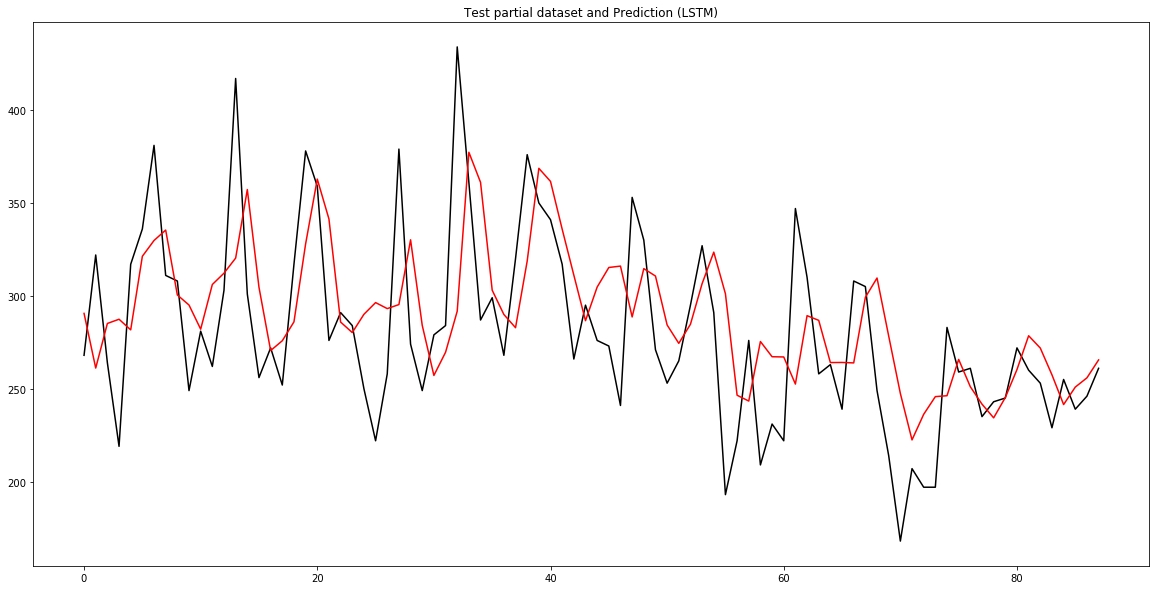

In [13]:
    if is_train == False:
        model_LSTM.load_weights('model_lstm_best.hd5')

    # lstm预测结果 (去掉test前部异常数据)
    
    testX, testY = create_dataset(test, seq_len)
    print(testX.shape, testY.shape)
    
    testPredict = model_LSTM.predict(testX)
    
    testPredict = scaler.inverse_transform(testPredict)
    testY_raw = scaler.inverse_transform(testY)
    
    testScore = np.mean(abs((testY_raw[0]-testPredict[:,0])/testY_raw[0]))
    print('Test Score: %.3f MAPE' % (testScore))
    
    # plot baseline and predictions    
    plt.figure(figsize=(20, 10))
    plt.title('Test partial dataset and Prediction (LSTM)')
    plt.plot(testY_raw, color='k', label='TRUE')
    plt.plot(testPredict, color='r', label='PRED')

    plt.show()

In [14]:
    if is_train:
        plt.figure(figsize=(20, 10))
        plt.title('Loss on training dataset')
        plt.xlabel('Iterations, batch size ' + str(batch_size))
        plt.ylabel('mean_squared_error')
        plt.plot(loss_LSTM.losses, color='k', label='LSTM')
        plt.plot(loss_PLSTM.losses, color='r', label='PLSTM')

        plt.show()

In [15]:
    if is_train:
        plt.figure(figsize=(20, 10))
        plt.title('Mape on training dataset')
        plt.xlabel('Iterations, batch size ' + str(batch_size))
        plt.ylabel('mape')
        plt.plot(mape_LSTM.losses, color='k', label='LSTM')
        plt.plot(mape_PLSTM.losses, color='r', label='PLSTM')

        plt.show()